### ovrlpy segmentation-free analysis script for Xenuim-benchmarking analysis

Salas et al, 2023

In [1]:
%load_ext autoreload
%autoreload 2


#### Basic imports:

In [2]:
import os
import pandas as pd
import anndata
import numpy as np
import ssam
import tqdm
from src import ovrlp

#### Parameter definitions:

In [3]:
### Global variables:

n_slide = 1  # [can be 1-3]

### ovrlpy analysis:

kde_bandwidth_um = 2.5
ovrlpy_vf_um_per_px = 2.5

### Prepare paths/locations:

data_path = '/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/'


#### Data loader:

In [4]:

# coordinate data exists inside the anndata object's uns['spots'] field:
adata = anndata.read_h5ad(os.path.join(data_path, 'spatial',f'ms_brain_multisection{n_slide}.h5ad'))
coordinate_df = adata.uns['spots'].copy()[['x_location', 'y_location','z_location','feature_name']]
coordinate_df.columns = ['x', 'y', 'z', 'gene']
coordinate_df['z']*= 0
coordinate_df = coordinate_df[~(coordinate_df.gene.str.contains("BLANK") | coordinate_df.gene.str.contains("NegControl"))]
coordinate_df['gene'] = coordinate_df['gene'].astype('category')


# shift coordinates to be positive:
coordinate_df[['x', 'y', 'z']] = coordinate_df[['x', 'y', 'z']] - coordinate_df[['x', 'y', 'z']].min()

# get a list of all genes for convenience:
genes = coordinate_df['gene'].cat.categories.tolist()
genes

,x,y,z,gene
transcript_id,,,,
281474976710664,4843.0460,6427.7300,19.068869,Bhlhe40
281474976710665,4844.6330,6223.1826,18.520160,Parm1
281474976710667,4842.9434,6478.3105,18.500109,Bhlhe40
281474976710669,4843.9414,6344.5503,15.016154,Lyz2
281474976710670,4843.1626,6632.1120,15.394680,Dkk3
...,...,...,...,...
281977488696810,3656.9348,5991.1730,14.609873,Zfp536
281977488696812,3656.0498,5359.0933,17.772276,Parm1
281977488696814,3656.7720,5429.7690,15.828760,Meis2


In [ ]:
coordinate_df.to_csv(os.path.join('coordinate_df.csv'))

In [62]:
coordinate_df.x-=coordinate_df.x.min()
coordinate_df.y-=coordinate_df.y.min()

coordinate_df.x/=ovrlpy_vf_um_per_px
coordinate_df.y/=ovrlpy_vf_um_per_px

In [63]:
from src import ovrlp

roi_df = ovrlp.find_overlaps(coordinate_df,threshold_fraction=0.4,density_weight=0.3,min_distance=20)
# _=ovrlp.assign_xy(coordinate_df)
roi_df

,x,y,divergence
0,106,1126,19.447874
1,152,1359,17.030547
2,184,824,19.634017
3,195,799,17.379476
4,198,1354,17.192399
...,...,...,...
833,3883,1194,17.933546
834,3885,1573,17.394201
835,3908,1524,18.776811
836,3922,1322,18.975837


#### Load snRNAseq data for cell typing:

In [65]:
# We assign each spot to the nearest celltype, using an annotated single-cell dataset:

# Load the single-cell dataset:
adata_snrna = anndata.read_h5ad('/dh-projects/ag-ishaque/analysis/tiesmeys/data/10-X-mouse-brain-scrna/adata_multisection_withclusters_only_nuclei_annotation.h5ad')
adata_snrna = adata_snrna[:,adata_snrna.var.index.isin(genes)]
adata_snrna.obs = adata_snrna.obs[['celltype_annotation']]

# Load the single-cell dataset:
# adata_scrna = anndata.read_h5ad('../../data/z-incoherence/counts_WS_blur5_exp0.h5ad')
# adata_scrna = adata_scrna[:,adata_scrna.var.index.isin(genes)]
# adata_scrna.obs = adata_scrna.obs[['celltype']]

# adata_sncrna = anndata.concat([adata_snrna,adata_scrna],axis=0,join='outer')
adata_sncrna = adata_snrna
adata_sncrna.obs['celltype_coarse'] = adata_sncrna.obs.celltype_annotation.apply(lambda x: x.split(' ')[0])

adata_sncrna.obs.index = ('Cell_'+pd.Series(np.arange(adata_sncrna.shape[0])).astype(str)).values

# del adata_snrna,adata_scrna

# define a signature matrix of mean celltype expression profiles:
celltypes = sorted(adata_sncrna.obs.celltype_coarse.unique())
signatures = pd.DataFrame(index=genes,columns=celltypes).drop(['Noise','nan','?'],axis=1)

# fill the signatures with mean expression values:
for celltype in signatures.columns:
    subset = adata_sncrna.X[adata_sncrna.obs.celltype_coarse==celltype,:]
    subset = pd.Series(np.nan_to_num(np.array(subset.mean(0)).squeeze()),
                       index=adata_sncrna.var.index)

    signatures[celltype] = subset[genes].values / (subset.sum()+1)


/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [66]:
len(roi_df)

838

Plotting case 20
Plotting case 90
Plotting case 160


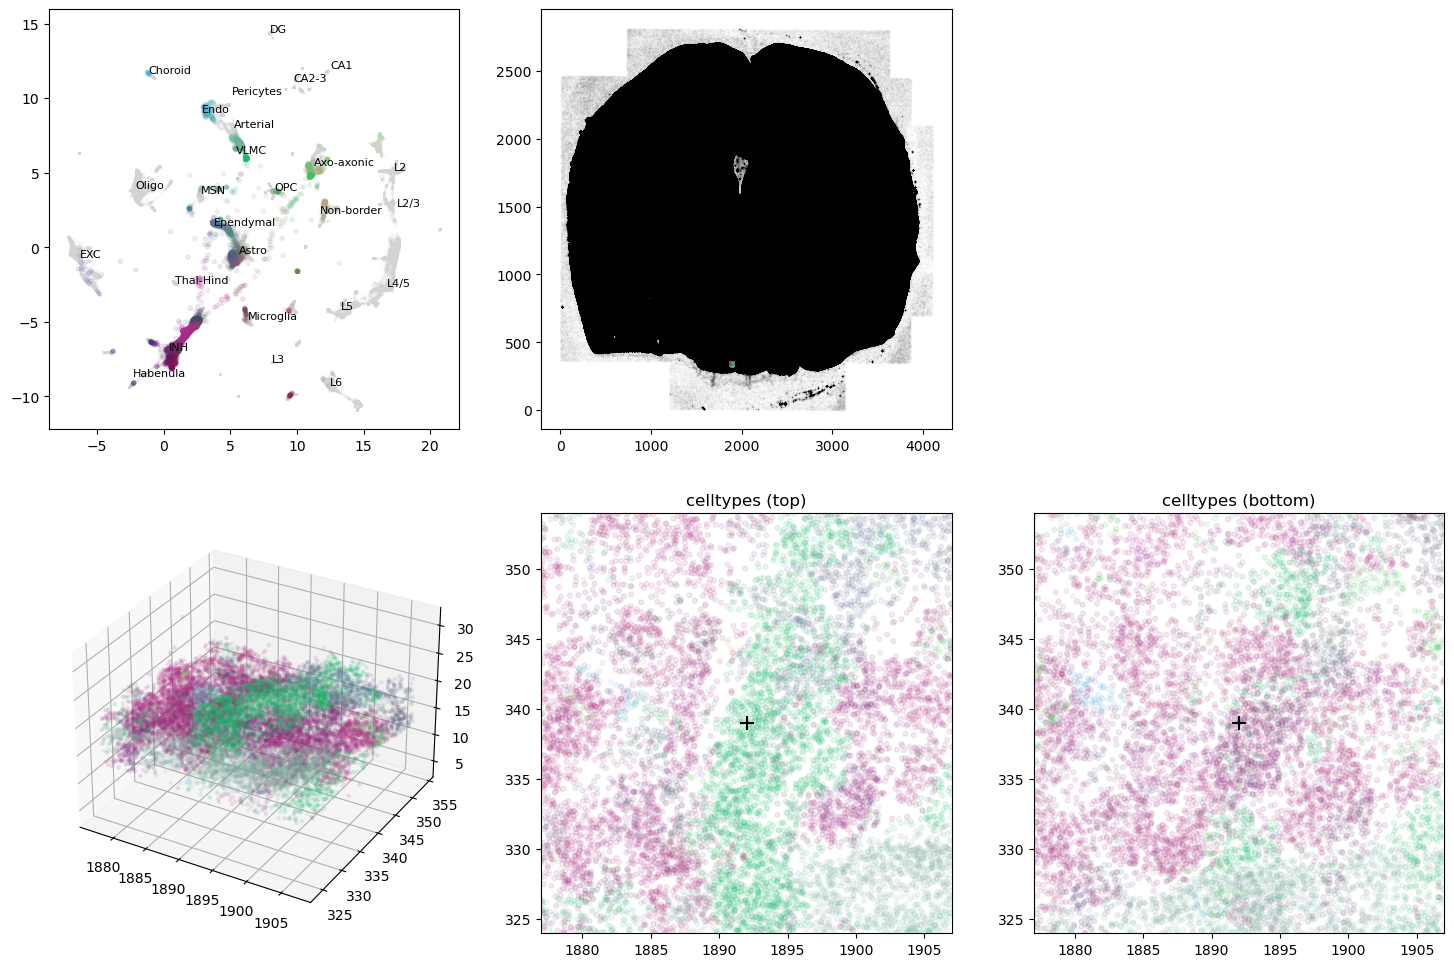

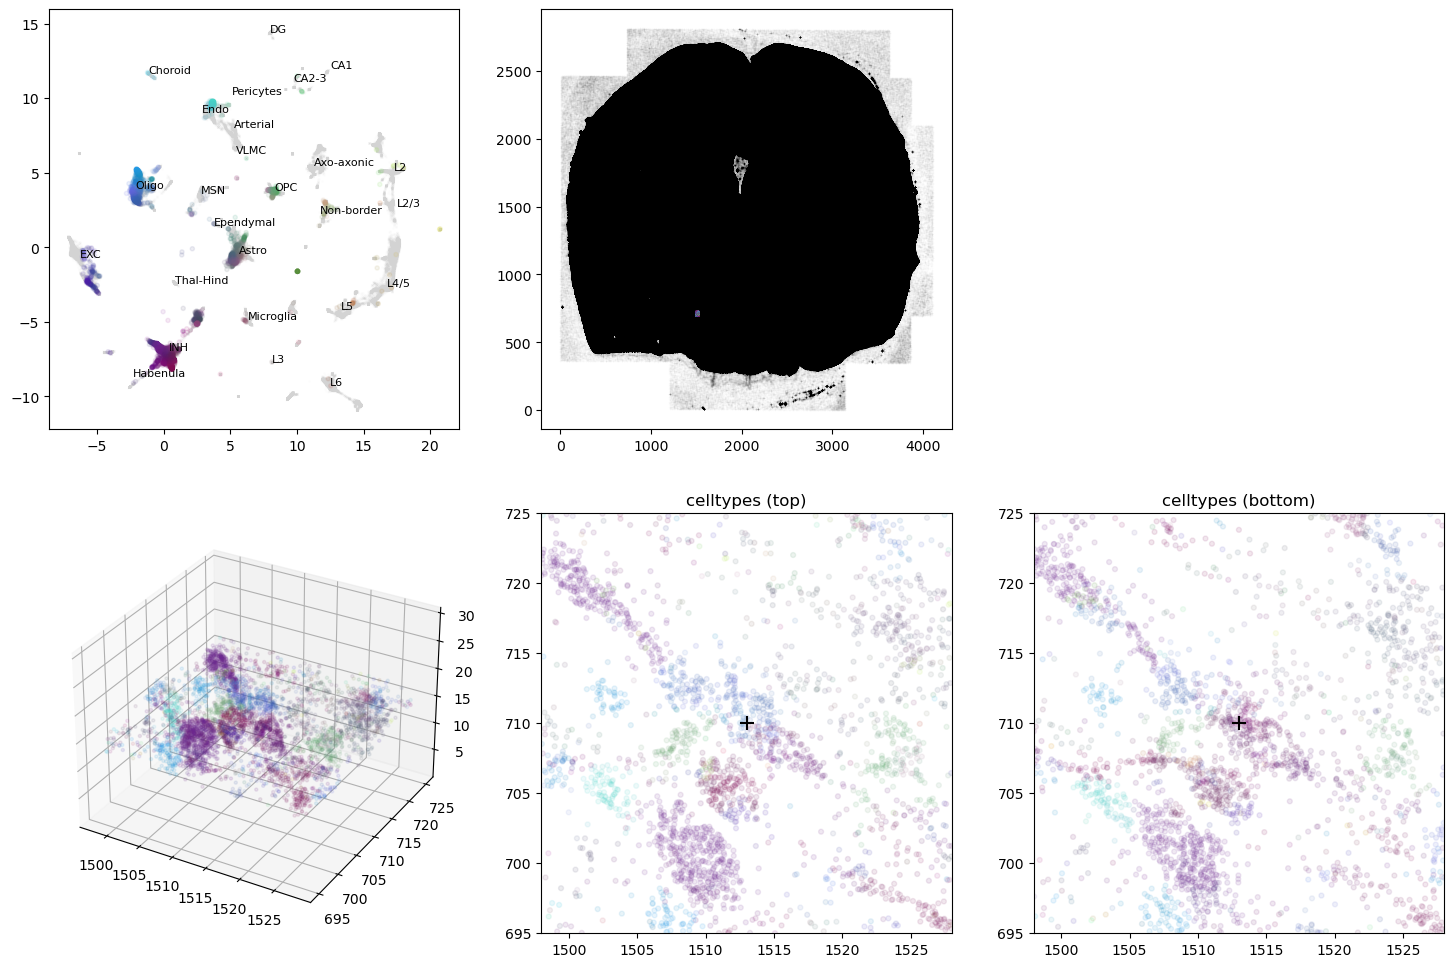

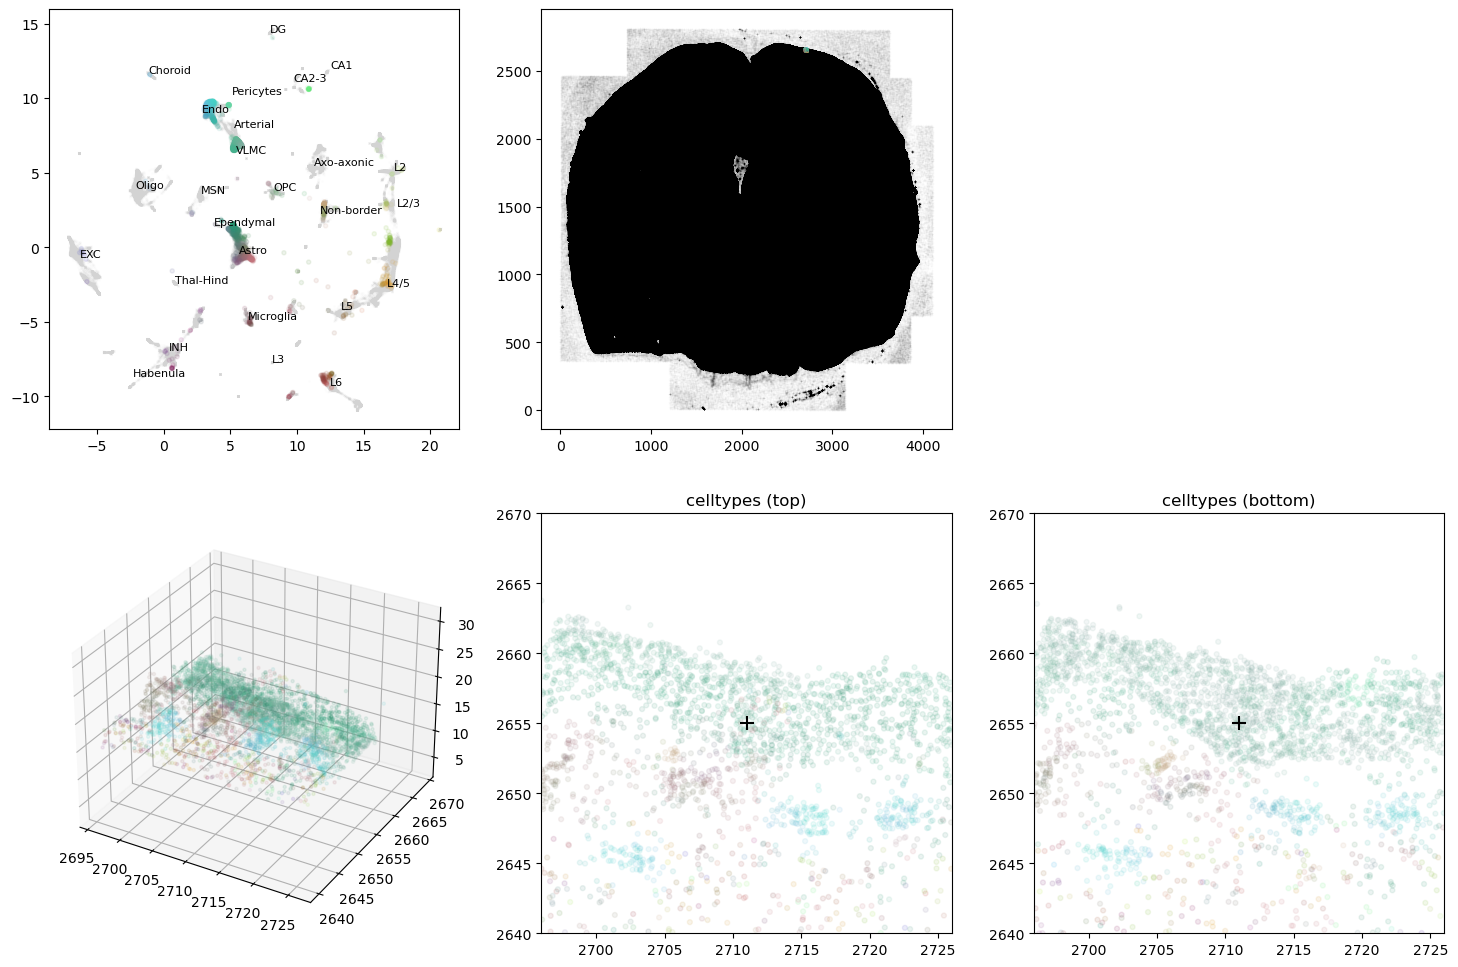

In [67]:
# assert False

ovrlp.visualize_rois(coordinate_df,roi_df, signature_matrix=signatures,
                     celltyping_min_expression=5,
                     n_cases=range(0,5,1),plot_window_size=15)

''

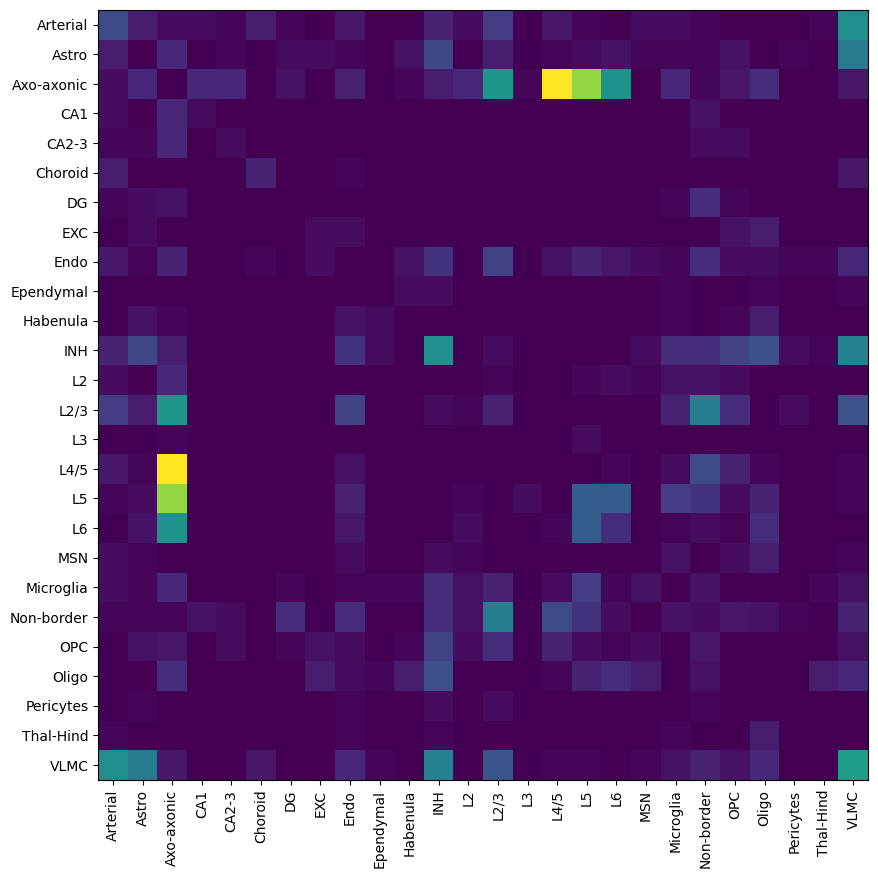

In [68]:
expressions_top = ovrlp.get_expression_vectors_at_rois(df = coordinate_df[coordinate_df.z>coordinate_df.z_delim], rois_x=roi_df.x,
                                        rois_y=roi_df.y,genes=genes)

expressions_bottom = ovrlp.get_expression_vectors_at_rois(df = coordinate_df[coordinate_df.z<coordinate_df.z_delim], rois_x=roi_df.x,
                                        rois_y=roi_df.y,genes=genes)

                                        

celltype_labels_top = ovrlp.determine_celltype_class_assignments(expressions_top,signatures)
celltype_labels_bottom = ovrlp.determine_celltype_class_assignments(expressions_bottom,signatures)

top_bottom_heatmap = np.zeros((len(signatures.columns),len(signatures.columns)))

for i in range(len(celltype_labels_top)):
    top_bottom_heatmap[celltype_labels_top[i],celltype_labels_bottom[i]]+=1#roi_df.divergence[i]
    top_bottom_heatmap[celltype_labels_bottom[i],celltype_labels_top[i]]+=1#roi_df.divergence[i]

plt.figure(figsize=(10,10))
plt.imshow(top_bottom_heatmap)
plt.xticks(range(len(signatures.columns)),signatures.columns,rotation=90)
plt.yticks(range(len(signatures.columns)),signatures.columns)

''